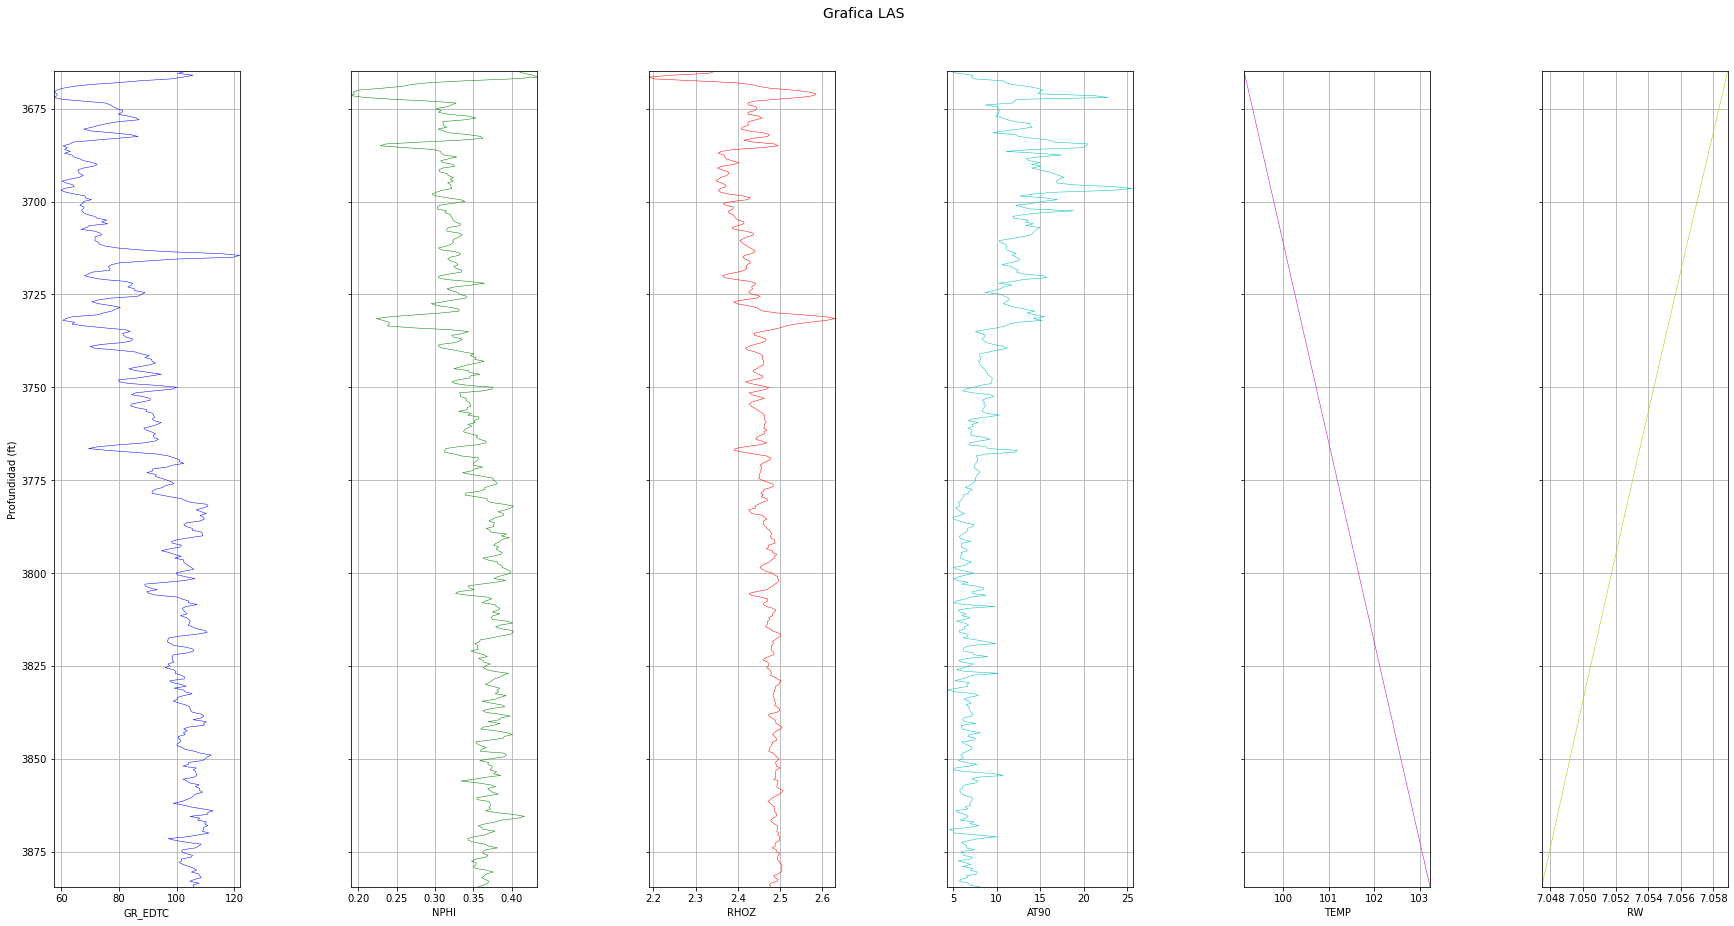

In [54]:
import numpy as np
import pandas as pd 
import lasio # siempre debo importarlo si necesito algun archivo lasio 
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from pandas import ExcelWriter #este va servir para exportar achivos a excel 
import xlrd

def df_plot(logs, log10=[]):
    '''
    Funcion de ploteo. La salida corresponde a los campos del df, todos a 
    escala lineal. Permite especificar campos para representar el eje x en 
    formato de escala logaritmica. 
    Los subplots son representados en linea horizontal. La función requiere 
    al menos dos subplots mas 'DEPTH' siempre como último registro en el df. 
    Este último será representado en 'y' en escala invertida.
    
    Parametros
    ------------
    logs : Dataframe
    Dataframe con todos los campos de interés 
    log10 : list
    Lista de campos a representar el formato del eje x  a escala log10
    '''
    
    logs = logs.sort_values(by='DEPTH')
    campos = logs.columns
    try:
        colores = ['b', 'g', 'r', 'c', 'm', 'y', 'k', 'w']
        f, ax = plt.subplots(nrows=1, ncols=(len(campos)-1), 
                             figsize=(((len(campos)-1)*5), 15))
        ax[0].set_ylabel("Profundidad (ft)")

        for i in range(len(campos)-1):
            #Registro con dato lineal pero el formato x a log10
            if campos[i] in log10: ax[i].set_xscale('log')
                
            ax[i].plot(logs[campos[i]], logs.DEPTH,lw = 0.5, #el lw sirve para acomodar elgrosor de la linea
                             color=colores[((i)%7)])
            ax[i].set_xlim(logs[campos[i]].min(), 
                                 logs[campos[i]].max())
            ax[i].set_ylim(logs.DEPTH.min(), logs.DEPTH.max())
            ax[i].invert_yaxis()
            ax[i].grid()
            ax[i].set_xlabel(campos[i])

        for x in range(1, len(ax)):
            ax[x].set_yticklabels([])
        plt.subplots_adjust(wspace=0.6)
        f.suptitle('Grafica LAS', 
                   fontsize=14, y=0.94)
    except:
        print('No es posible crear el gráfico. Podría ser que el dataframe \
            contiene menos de dos registros')
        


#############################################################################

#CODIGO PARA HALLAR LA PENDIENTE Y EL INTERCEPTO
ruta = "CALCULO_DE_RW.xlsx" # busco el archivo y lo pego con el indicativo por ejemplo .xlsx
df_reg = pd.read_excel(ruta, sheet_name='data_programar') #sacar del excel a python 
X = df_reg.iloc[:, 0].values.reshape(-1, 1)
Y = df_reg.iloc[:, 1].values.reshape(-1, 1)  
lr = LinearRegression()  
lr.fit(X, Y)  
#plt.scatter(X, Y) #scatter puntiada nube de puntos 
a = lr.coef_[0][0] #pendiente 
b = lr.intercept_[0] #intercepto
##########################################################################
#CALCULO DE TEMP Y RW
temp_super = 25
salinidad = 18000
kt1 = 6.77
rw_a_trw = (400000/temp_super/salinidad)**0.88
#primer archivo
las = lasio.read("registro_pozo1.las")
df = las.df()
df['TEMP'] = (df.DEPTH * a) + b #PARA CREAR AL COLUMNA EN LA GRAFICA
df['RW'] = rw_a_trw*(temp_super+kt1)/df.TEMP + kt1
df = df[['GR_EDTC', 'NPHI', 'RHOZ', 'AT90', "TEMP", "RW", 'DEPTH']] 
######################################################################
df = df.loc[(df.DEPTH>=3665) &  (df.DEPTH<=3885)]
df_plot(df)

#CAlCULO DE VSH
#segundo archivo
las_HO1 = lasio.read("registro_pozo1.las")
df_HO1 = las_HO1.df()
df_HO1 = df_HO1[["GR_EDTC", "RHOZ", "DEPTH"]]
df_HO1['Vsh'] = (df_HO1.GR_EDTC - 30) / (150 - 30)
###################################################################
#CALCULO DE LA POROSIDAD 
dens_shale = 2.8
dens_sand = 2.65
dens_flow = 1.13835
df_HO1["dens_grano"] = (df_HO1.Vsh*dens_shale)+(1-df_HO1.Vsh)*dens_sand
df_HO1["porosidad"] = (df_HO1.dens_grano - df_HO1.RHOZ)/(df_HO1.dens_grano - dens_flow)
########################################################################################################
#df = pd.concat([df_HO1, df], axis=1) #ambos dataframe concatenar permite unir tablas, axis=1 me permite decir una a un lado y otro al otro
df_HO1 = df_HO1.loc[(df_HO1.DEPTH>=3665) &  (df_HO1.DEPTH<=3885)]
df_plot(df_HO1[['Vsh', "dens_grano", 'porosidad', "DEPTH"]])

0     32
1     21
2     21
3     20
4     35
5     21
6     45
7     34
8     29
9     21
10    24
11    21
Name: vclay, dtype: int64

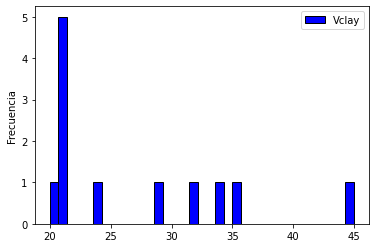

In [53]:
#HISTOGRAMA
#para encontrar una grafica de excel y ponerla aca CON EL VSH
ruta = "CALCULO_DE_RW.xlsx" # busco el archivo y lo pego con el indicativo por ejemplo .xlsx
df_nucleo = pd.read_excel(ruta, sheet_name='vclay') #sacar del excel a python
plt.hist(df_nucleo["vclay"],35, color="blue", ec="black", label="Vclay")
plt.ylabel("Frecuencia")
plt.legend()
df_nucleo.vclay

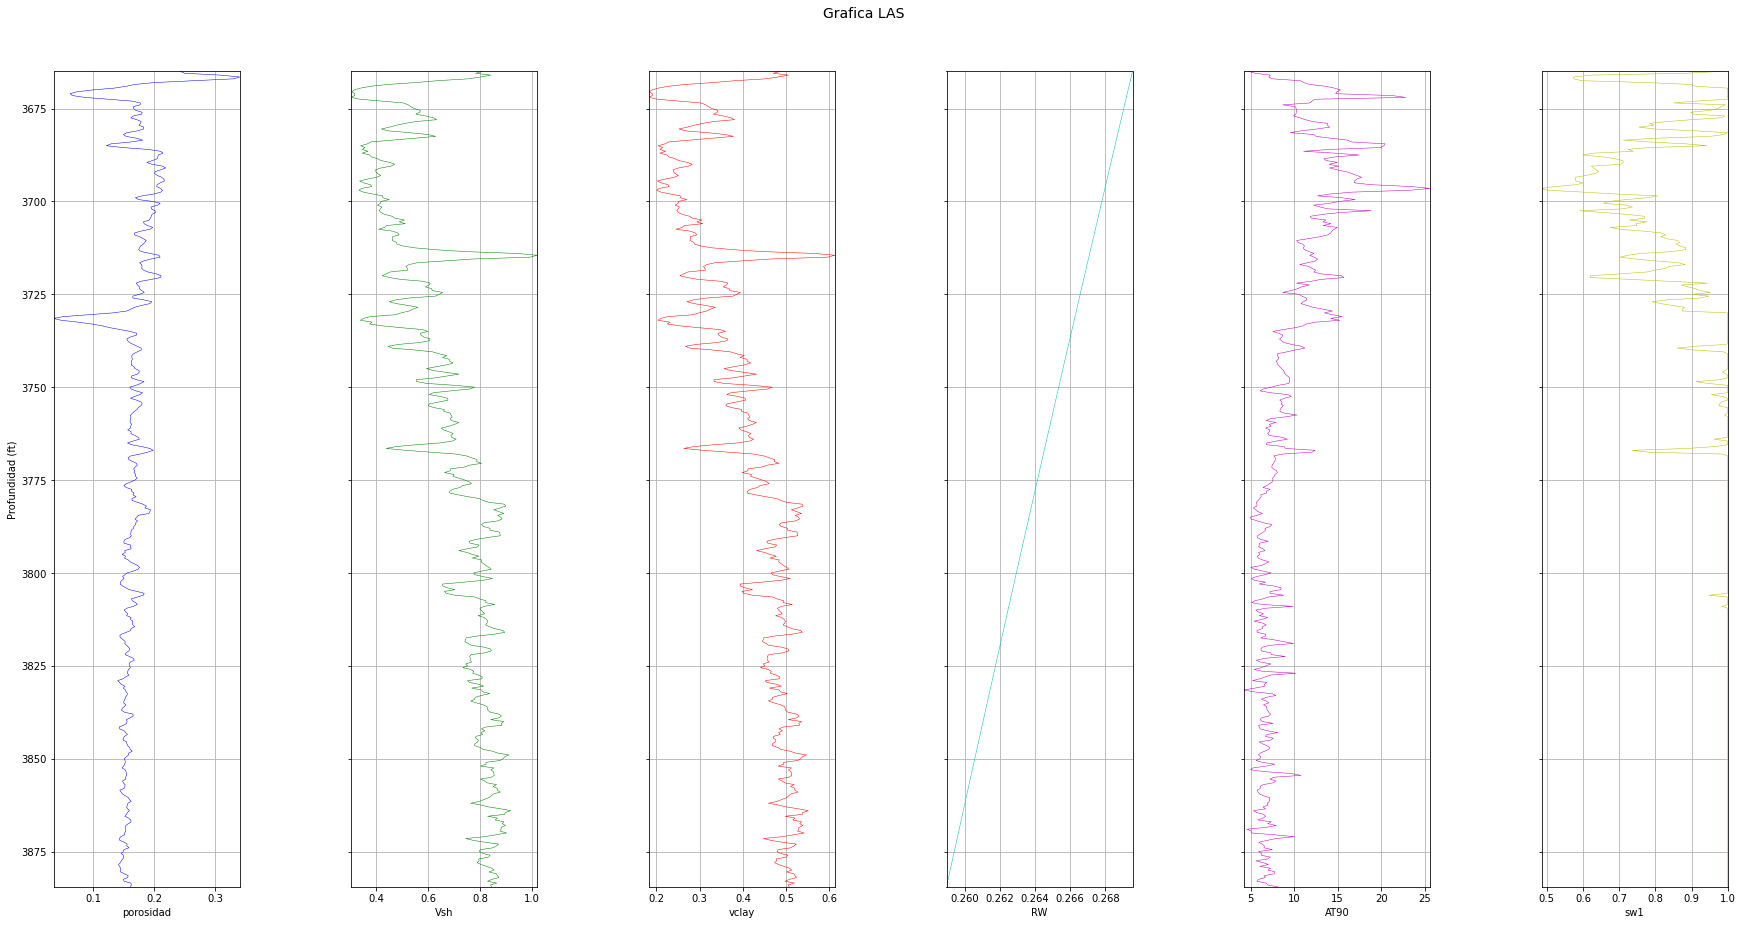

In [58]:
#CAlCULO DE VSH
#segundo archivo
las_HO1 = lasio.read("registro_pozo1.las")
df_HO1 = las_HO1.df()
df_HO1 = df_HO1[["GR_EDTC", "RHOZ", "DEPTH"]]
df_HO1['Vsh'] = (df_HO1.GR_EDTC - 30) / (120 - 30)
#################################################################################
#CALCULO DE VCLAY
df_HO1["vclay"] = df_HO1.Vsh * 0.6

###################################################################################
#CALCULO DE TEMP Y RW
temp_super = 25
salinidad = 18000
kt1 = 6.77
rw_a_trw = (400000/temp_super/salinidad)**0.88
df_HO1['TEMP'] = (df_HO1.DEPTH *0.0198) + 26.921 #PARA CREAR AL COLUMNA EN LA GRAFICA
df_HO1['RW'] = (rw_a_trw*(temp_super+kt1))/(df_HO1.TEMP + kt1)

#############################################################
#CALCULO DE LA POROSIDAD 
dens_shale = 2.75
dens_sand = 2.65
dens_flow = 1.13835
df_HO1["dens_grano"] = (df_HO1.Vsh*dens_shale)+(1-df_HO1.Vsh)*dens_sand
df_HO1["porosidad"] = (df_HO1.dens_grano - df_HO1.RHOZ)/(df_HO1.dens_grano - dens_flow)
########################################################################################################
#AT90
las_AT90 = lasio.read("registro_pozo1.las")
df_AT90 = las_AT90.df()
df_AT90 = df_AT90.AT90
df_HO1 = pd.concat([df_AT90, df_HO1], axis=1)
#################################################################################
#CALCULO DE LA SW
a = 1
n = 2
m = 2
df_HO1["sw"] = ((a*df_HO1.RW)/(df_HO1.AT90*(df_HO1.porosidad**m)))**(1/n)
df_HO1["sw1"] = np.where(df_HO1["sw"]>1,1,df_HO1["sw"]) #condicional 
df_HO1 = df_HO1.loc[(df_HO1.DEPTH>=3665) &  (df_HO1.DEPTH<=3885)]
df_plot(df_HO1[["porosidad", 'Vsh', "vclay", 'RW', "AT90", "sw1", "DEPTH"]])

#ESTO ME SIRVE PARA PONER UN ARCHIVO DATA FRAME EN UN EXCEL
ruta_out = r'RESTA_REGITROS_GR.xlsx'
writer = ExcelWriter(ruta_out) #para pasar un dataframe a un excel 
df_HO1.to_excel(writer, sheet_name='RESTA', index=True, merge_cells=False) #SHEET_NAME ES EL NOMBRE DE LA HOJA EN EXCEL
writer.save() #para guardar el archivo en mis documentos

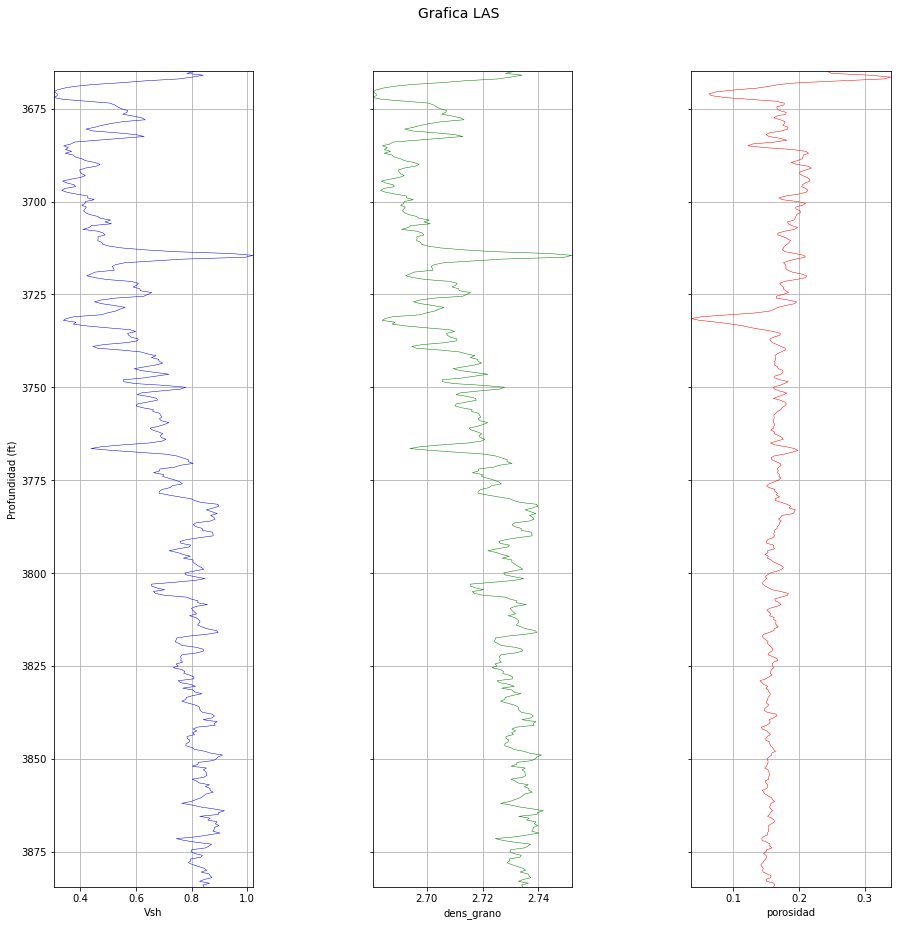

In [59]:
#df = pd.concat([df_HO1, df], axis=1) #ambos dataframe concatenar permite unir tablas, axis=1 me permite decir una a un lado y otro al otro
df_HO1 = df_HO1.loc[(df_HO1.DEPTH>=3665) &  (df_HO1.DEPTH<=3885)]
df_plot(df_HO1[['Vsh', "dens_grano", 'porosidad', "DEPTH"]])